# What is FastGAN?

Paper: https://arxiv.org/pdf/2101.04775.pdf

In short, it is a light-weight GAN structure that allows for high fidelity images to be created at a very low compute cost (possible to train to convergence within a day on an RTX 2080 TI).

**Key contributions:**
- Skip-Layer channel-wise Excitation module
- Discriminator that acts as a self-supervised model that's trained as an autoencoder 

# Architecture

### Skip-Layer channel-wise Excitation (SLE)

![SLE](SLE.JPG)

The idea behind SLE originates from ResBlocks in [ResNets](https://arxiv.org/pdf/1512.03385.pdf). If you take a look *Figure 2*, it shows the basic idea of skip connections. Since this is tensor addition, we require the activation $\mathcal{F}(\mathbf{x}) + \mathbf{x}$ to be of the same spatial dimension, thus we cannot have skip connections over different (and consequently long range) spatial dimensions. However, the main takeaway from the ResNet paper is that these skip connections improve gradient flow during the backward pass. Now in having a structure like the proposed SLE, it allows for the model to have a deeper generator/discriminator without compromising gradient flow. However, unlike a ResBlock, the two activations no longer need to have the same spatial dimensions since we apply channel wise multiplications across channels (notice how the right hand side convolves down to a spatial dimension of $1 \times 1$). Additionally, since we no longer require the two activations to have the same spatial dimensions, we can apply this shortcut over a far longer range of spatial dimensions i.e. between $16 \times 16$ and $256 \times 256$ (since one side always convolves down to a spatial dimension of $1 \times 1$) instead of being restricted to a smaller difference in dimensions as you would've been if using the ResNet skip-layer architecture.

Another inefficiency of ResBlocks was that since they required the two activations to be of the same shape, which would be done using convolutions. This induces a heavy computation cost and also increases time required for both the forward and backward pass. In making it so that we now perform channel-wise multiplication instead of addition, we can avoid the heavy cost of convolutions since one side now has a spatial dimension of $1 \times 1$. In conclusion, we get far greater gradient flow without extra computation burden.

Talking a bit more about the layers involved in this module, the activations with the smaller spatial dimension are sent down the right-hand side of the above diagram. The adaptive pooling reduces the spatial dimension of any input to $4 \times 4$ and the next convolution drops this down to a spatial dimension of $1 \times 1$. It finally goes through activations and one last convolution layer (which in this case is setup so it does not affect the number of output channels).

## Generator

![Generator](Generator.JPG)

The input here is a vector of size $(256, 1, 1)$ using the *Channel, Height, Width* convention. The numbers within the orange boxes represent the output spatial dimension for that respective layer. The blue arrows represent the same upsampling structure which is shown in the blue box on the top left. The sampling structure is as follows: upsizing using torch image utils followed by a convolution (note that a $3 \times 3$ convolution with stride and padding of $1$ does not change spatial dimensions, rather is only used to change number of channels), batchnorm and GLU (additionally note that GLU halves the number of output channels - check codebase for more details). The final layer uses the same aforementioned convolution structure, but is now used to make sure the number of output channels is $3$ (for RGB). The Tanh activation makes the values clamped between -1 and 1.

## Discriminator

![Discriminator](Discriminator.JPG)

**Note:** The Simple Decoder block shown in the top right includes an adaptive average pool of $8 \times 8$ before the four sub-blocks.

Assume that the input image here has a size of $1024 \times 1024$. Additionally, the input image can either be real or fake. Both cases are described in detail below:

- **Real:** We create a copy of the real image that is resized down to $128 \times 128$ named $I$. Additionally, we randomly crop the real image from one of the four quadrants, and resize the resulting $512 \times 512$ image to $128 \times 128$ called $I_{part}$. The real image is sent down a block of two convolution layers (and activations + batchnorm) that put the spatial dimensions at $256 \times 256$. After this, the feature maps are sent down to different paths and summed together at the end to produce the next set of feature maps. One side downsamples using convolutions and the other side downsamples using average pooling. This process is the same wherever a blue arrow is visible in the above diagram. Finally, at the spatial dimension of $16 \times 16$, we take a crop from the same quadrant as we did for $I_{part}$ which results in a $8 \times 8$ feature map. This is then passed into the decoder which resizes to double the spatial size and passes through convolutions each sub-block in order to reach $I^{'}_{part}$ with spatial dimensions $128 \times 128$. Similarly, the feature map with dimension $8 \times 8$ is passed through a decoder as well which results in $I^{'}$ with spatial dimensions $128 \times 128$. At the end, another set of convolutions and vector unraveling gives a scoring of shape $(25, 1)$ and we take the mean of this as part of our loss.
- **Fake:** This follows the exact same steps as the real case, however, it does not include any of the cropping or decoding work we did in the real case (since we only want to train the decoder to learn better features from the images that are real), so the only output from the model in this case is the score of shape $(25, 1)$ at the very end.

Finally, note that unfortunately there exist some discrepancies between the paper's codebase and the paper itself and this was something that originated from the authors, though the main ideas given here remain the same. For more details, please take a look at the code provided. 

## Loss

![Loss](Loss.jpg)

The discriminator makes use of a hinge-loss as it is fast to compute, and the $\mathcal{L}_{recons}$ part of the loss is the reconstruction error between $I$ and $I^{'}$, and $I_{part}$ and $I^{'}_{part}$ respectively. In the code base, this is done using [perceptual loss](https://arxiv.org/pdf/1801.03924.pdf). As for the generator, it only takes the score that's output by the discriminator in the fake case and uses its mean as the loss.

# Inference Code

In [17]:
from models import (
    conv2d,
    convTranspose2d,
    batchNorm2d,
    GLU,
    NoiseInjection,
    Swish,
    SEBlock,
    InitLayer,
    UpBlock,
    UpBlockComp,
    DownBlock,
    DownBlockComp
)
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt

## Models

In [28]:
class Generator(nn.Module):
    def __init__(self, ngf=64, nz=100, nc=3, im_size=1024):
        super(Generator, self).__init__()

        nfc_multi = {4:16, 8:8, 16:4, 32:2, 64:2, 128:1, 256:0.5, 512:0.25, 1024:0.125}
        nfc = {}
        for k, v in nfc_multi.items():
            nfc[k] = int(v*ngf)

        self.im_size = im_size
        
        # the very initial block as shown in the diagram
        self.init = InitLayer(nz, channel=nfc[4])
        
        # the blocks shown in blue arrows. The code differs from the paper here as it makes use of alternating types of 
        # blocks. More details can be found in the codebase and observing the layer classes.
        self.feat_8   = UpBlockComp(nfc[4], nfc[8])
        self.feat_16  = UpBlock(nfc[8], nfc[16])
        self.feat_32  = UpBlockComp(nfc[16], nfc[32])
        self.feat_64  = UpBlock(nfc[32], nfc[64])
        self.feat_128 = UpBlockComp(nfc[64], nfc[128])  
        self.feat_256 = UpBlock(nfc[128], nfc[256]) 
        
        # these are the SE blocks used as shown in the diagram (however there is a difference that they are applied to 
        # different spatial dimensions and this difference is not accounted for by the authors)
        self.se_64  = SEBlock(nfc[4], nfc[64])
        self.se_128 = SEBlock(nfc[8], nfc[128])
        self.se_256 = SEBlock(nfc[16], nfc[256])
        
        # outputs a 128 x 128 image with 3 channels (RGB) for the discriminator to use
        self.to_128 = conv2d(nfc[128], nc, 1, 1, 0, bias=False) 
        # outputs a 1024 x 1024 image with 3 channels (RGB) that can be saved and also be used by the discriminator
        self.to_big = conv2d(nfc[im_size], nc, 3, 1, 1, bias=False) 
        
        if im_size > 256:
            self.feat_512 = UpBlockComp(nfc[256], nfc[512]) 
            self.se_512 = SEBlock(nfc[32], nfc[512])
        if im_size > 512:
            self.feat_1024 = UpBlock(nfc[512], nfc[1024])  
        
    def forward(self, input):
        
        feat_4   = self.init(input)
        feat_8   = self.feat_8(feat_4)
        feat_16  = self.feat_16(feat_8)
        feat_32  = self.feat_32(feat_16)
        
        feat_64  = self.se_64( feat_4, self.feat_64(feat_32) )

        feat_128 = self.se_128( feat_8, self.feat_128(feat_64) )

        feat_256 = self.se_256( feat_16, self.feat_256(feat_128) )

        if self.im_size == 256:
            return [self.to_big(feat_256), self.to_128(feat_128)]
        
        feat_512 = self.se_512( feat_32, self.feat_512(feat_256) )
        if self.im_size == 512:
            return [self.to_big(feat_512), self.to_128(feat_128)]

        feat_1024 = self.feat_1024(feat_512)

        to_128 = self.to_128(feat_128)
        to_big = self.to_big(feat_1024)

        im_128 = torch.tanh(to_128)
        im_1024 = torch.tanh(to_big)

        return [im_1024, im_128]

class Discriminator(nn.Module):
    def __init__(self, ndf=64, nc=3, im_size=512):
        super(Discriminator, self).__init__()
        self.ndf = ndf
        self.im_size = im_size

        nfc_multi = {4:16, 8:16, 16:8, 32:4, 64:2, 128:1, 256:0.5, 512:0.25, 1024:0.125}
        nfc = {}
        for k, v in nfc_multi.items():
            nfc[k] = int(v*ndf)
        
        # depending on input size, the initial block -as shown in the diagram- varies
        if im_size == 1024:
            self.down_from_big = nn.Sequential(
                                    conv2d(nc, nfc[1024], 4, 2, 1, bias=False),
                                    nn.LeakyReLU(0.2, inplace=True),
                                    conv2d(nfc[1024], nfc[512], 4, 2, 1, bias=False),
                                    batchNorm2d(nfc[512]),
                                    nn.LeakyReLU(0.2, inplace=True))
        elif im_size == 512:
            self.down_from_big = nn.Sequential( 
                                    conv2d(nc, nfc[512], 4, 2, 1, bias=False),
                                    nn.LeakyReLU(0.2, inplace=True))
        elif im_size == 256:
            self.down_from_big = nn.Sequential( 
                                    conv2d(nc, nfc[512], 3, 1, 1, bias=False),
                                    nn.LeakyReLU(0.2, inplace=True))
        
        # each DownBlockComp layer contains the two blocks that are found at each blue arrow in the diagram
        self.down_4  = DownBlockComp(nfc[512], nfc[256])
        self.down_8  = DownBlockComp(nfc[256], nfc[128])
        self.down_16 = DownBlockComp(nfc[128], nfc[64])
        self.down_32 = DownBlockComp(nfc[64],  nfc[32])
        self.down_64 = DownBlockComp(nfc[32],  nfc[16])
        
        # block used to build the score at the discriminator's output
        self.rf_big = nn.Sequential(
                            conv2d(nfc[16] , nfc[8], 1, 1, 0, bias=False),
                            batchNorm2d(nfc[8]), nn.LeakyReLU(0.2, inplace=True),
                            conv2d(nfc[8], 1, 4, 1, 0, bias=False))
        
        # this is a discrepancy that is not noted in the paper, but the authors make use of SLE in the
        # discriminator as well
        self.se_2_16 = SEBlock(nfc[512], nfc[64])
        self.se_4_32 = SEBlock(nfc[256], nfc[32])
        self.se_8_64 = SEBlock(nfc[128], nfc[16])
        
        # used to downsample images with dimensions (128 x 128) to dimensions (8 x 8). More information given
        # when talking about decoders below
        self.down_from_small = nn.Sequential( 
                                            conv2d(nc, nfc[256], 4, 2, 1, bias=False), 
                                            nn.LeakyReLU(0.2, inplace=True),
                                            DownBlock(nfc[256],  nfc[128]),
                                            DownBlock(nfc[128],  nfc[64]),
                                            DownBlock(nfc[64],  nfc[32]))
        
        # another discrepancy that is not noted in the paper, but it takes the smaller sized (128 x 128)
        # image that is passed in as input and also converts it to be a part of the score that is output
        # by the discriminator. Note that the output of this block and the output of self.rf_big is 
        # concatenated before returning the final score
        self.rf_small = conv2d(nfc[32], 1, 4, 1, 0, bias=False)
        
        # the diagram shows two decoders, but the codebase uses three. decoder_part is for decoding the
        # cropped part of the image, decoder_big is for decoding and recreating the original image at
        # dimensions (128 x 128) by passing in the last feature map which is the one with spatial dimension
        # (8 x 8). Before explaining decoder_small, we must note that during the forward pass, the discriminator
        # takes in a list of two sets of images. The first set contains the original image at size, for example,
        # (1024 x 1024) and the second set is the original image resized down to (128 x 128). This resized down
        # image is first resized down to (8 x 8) through convolutions using self.down_from_small, and it is then
        # passed into decoder_small to recreate the original image at dimensions (128 x 128). Unfortunately, 
        # decoder_small was not documented in the paper and is only found in the code as is the case with a few
        # of the other aforementioned changes.
        self.decoder_big = SimpleDecoder(nfc[16], nc)
        self.decoder_part = SimpleDecoder(nfc[32], nc)
        self.decoder_small = SimpleDecoder(nfc[32], nc)
        
    def forward(self, imgs, label, part=None):
        if type(imgs) is not list:
            imgs = [F.interpolate(imgs, size=self.im_size), F.interpolate(imgs, size=128)]
        feat_2 = self.down_from_big(imgs[0])
        feat_4 = self.down_4(feat_2)
        feat_8 = self.down_8(feat_4)
        
        feat_16 = self.down_16(feat_8)
        feat_16 = self.se_2_16(feat_2, feat_16)

        feat_32 = self.down_32(feat_16)
        feat_32 = self.se_4_32(feat_4, feat_32)
        
        feat_last = self.down_64(feat_32)
        feat_last = self.se_8_64(feat_8, feat_last)

        rf_0 = self.rf_big(feat_last).view(-1)

        feat_small = self.down_from_small(imgs[1])
        
        rf_1 = self.rf_small(feat_small).view(-1)

        if label=='real':    
            rec_img_big = self.decoder_big(feat_last)
            rec_img_small = self.decoder_small(feat_small)

            assert part is not None
            rec_img_part = None
            if part==0:
                rec_img_part = self.decoder_part(feat_32[:,:,:8,:8])
            if part==1:
                rec_img_part = self.decoder_part(feat_32[:,:,:8,8:])
            if part==2:
                rec_img_part = self.decoder_part(feat_32[:,:,8:,:8])
            if part==3:
                rec_img_part = self.decoder_part(feat_32[:,:,8:,8:])

            return torch.cat([rf_0, rf_1]) , [rec_img_big, rec_img_small, rec_img_part]

        return torch.cat([rf_0, rf_1]) 


class SimpleDecoder(nn.Module):
    """docstring for CAN_SimpleDecoder"""
    def __init__(self, nfc_in=64, nc=3):
        super(SimpleDecoder, self).__init__()

        nfc_multi = {4:16, 8:8, 16:4, 32:2, 64:2, 128:1, 256:0.5, 512:0.25, 1024:0.125}
        nfc = {}
        for k, v in nfc_multi.items():
            nfc[k] = int(v*32)
        
        # the sub-blocks shown in the decoder block in the diagram
        def upBlock(in_planes, out_planes):
            block = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='nearest'),
                conv2d(in_planes, out_planes*2, 3, 1, 1, bias=False),
                batchNorm2d(out_planes*2), GLU())
            return block

        self.main = nn.Sequential(nn.AdaptiveAvgPool2d(8),
                                upBlock(nfc_in, nfc[16]),
                                upBlock(nfc[16], nfc[32]),
                                upBlock(nfc[32], nfc[64]),
                                upBlock(nfc[64], nfc[128]),
                                conv2d(nfc[128], nc, 3, 1, 1, bias=False),
                                nn.Tanh())

    def forward(self, input):
        return self.main(input)

def load_params(model, new_param):
    for p, new_p in zip(model.parameters(), new_param):
        p.data.copy_(new_p)

## Loading weights

In [47]:
# choose from "pokemon" or "cat"
category = "pokemon"
batch_size = 8

In [48]:
gen = Generator(ngf=64, nz=256, im_size=1024)
device = torch.device('cuda:0')
weights = torch.load(
    f"/ssd003/projects/aieng/public/synthetic_datasets/fastGAN/torch_weights/torch_fastgan_{category}/models/all_50000.pth"
)
load_params(gen, weights['g_ema'])
gen.to(device)

Generator(
  (init): InitLayer(
    (init): Sequential(
      (0): ConvTranspose2d(256, 2048, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GLU()
    )
  )
  (feat_8): Sequential(
    (0): Upsample(scale_factor=2.0, mode=nearest)
    (1): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (2): NoiseInjection()
    (3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): GLU()
    (5): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): NoiseInjection()
    (7): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): GLU()
  )
  (feat_16): Sequential(
    (0): Upsample(scale_factor=2.0, mode=nearest)
    (1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, a

## Generating images

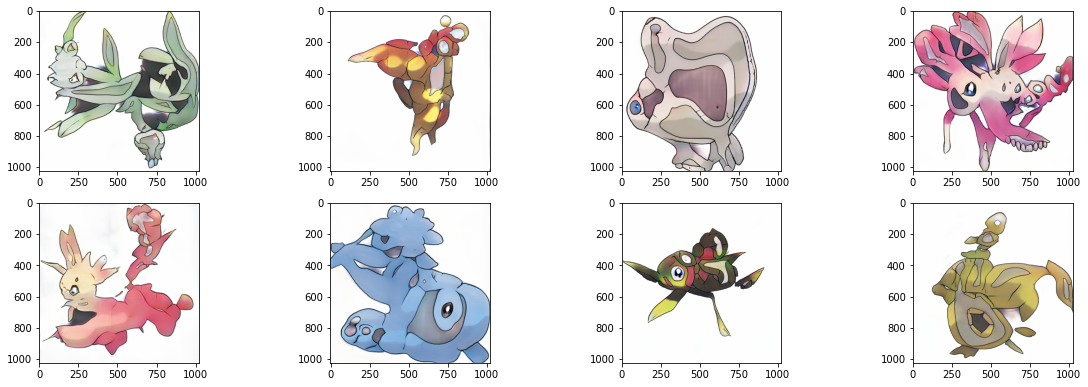

In [57]:
# generate gaussian noise
noise = torch.randn(batch_size, 256).to(device)
with torch.no_grad():
    # retrieve the first index of the returned values from the generator (since it returns 1024 x 1024 and 128 x 128 images)
    # and normalize
    imgs = gen(noise)[0].add(1).mul(0.5)
    
    # convert to np array and reorder dims so they're in the correct order for displaying
    npimg = imgs.cpu().numpy().transpose(0, 2, 3, 1)

    plt.figure(figsize=(20,10))
    columns = 4
    for i, image in enumerate(npimg):
        plt.subplot(len(npimg) // columns + 1, columns, i + 1)
        plt.imshow(image)